<a href="https://colab.research.google.com/github/bacetiner/BRAILS/blob/master/CNN_HandsOn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

If you are running this on Colab, please make sure to change your Runtime Type to GPU.

## Import required packages:


In [9]:
%matplotlib inline

In [1]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import random

## Install the latest version of BRAILS:

In [2]:
!pip install git+https://github.com/NHERI-SimCenter/BRAILS

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/NHERI-SimCenter/BRAILS to /tmp/pip-req-build-27qo7pbt
  Running command git clone -q https://github.com/NHERI-SimCenter/BRAILS /tmp/pip-req-build-27qo7pbt
     |████████████████████████████████| 125 kB 6.7 MB/s 
     |████████████████████████████████| 512 kB 48.9 MB/s 
  Created wheel for BRAILS: filename=BRAILS-2.0.1.dev404+g791f033-py3-none-any.whl size=9149836 sha256=baab762bffe507ed8b7e9069dfe6bc461f7c9b9cf5a5cefaed9a5f0d502eb80e
  Stored in directory: /tmp/pip-ephem-wheel-cache-d6_htc_9/wheels/95/f4/e3/a6a0d6655270cc9295155895448d84860de3e7b8a1f4fa8840
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=452c1c1c179bdde75ea4f4a0ef1137f43e92efdc48a91c7b253191481d2aab7d
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built BRAILS wget


## Download PEER Hub ImageNet Φ-Net Data for Building Collapse Mode
For general info on the dataset please visit: https://apps.peer.berkeley.edu/phi-net/download/

The download link for the data: https://apps.peer.berkeley.edu/phichallenge/dataset/3ddwa5567



In [3]:
!wget -O data.zip https://apps.peer.berkeley.edu/phichallenge/dataset/3ddwa5567
!unzip data.zip

--2022-07-26 12:57:32--  https://apps.peer.berkeley.edu/phichallenge/dataset/3ddwa5567
Resolving apps.peer.berkeley.edu (apps.peer.berkeley.edu)... 128.32.143.24, 2607:f140:0:f::24
Connecting to apps.peer.berkeley.edu (apps.peer.berkeley.edu)|128.32.143.24|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://apps.peer.berkeley.edu/phichallenge/dataset/task5_collapse_mode.zip [following]
--2022-07-26 12:57:32--  https://apps.peer.berkeley.edu/phichallenge/dataset/task5_collapse_mode.zip
Reusing existing connection to apps.peer.berkeley.edu:443.
HTTP request sent, awaiting response... 200 OK
Length: 232967101 (222M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>] 222.17M   144MB/s    in 1.5s    

2022-07-26 12:57:33 (144 MB/s) - ‘data.zip’ saved [232967101/232967101]

Archive:  data.zip
   creating: task5/
  inflating: task5/task5_X_test.npy  
  inflating: task5/task5_y_test.npy  
  inflating: task5/task5_X_train.n

##Preprocess Φ-Net Data:
Φ-Net stores image data as a one big numpy array. These images are saved in BGR format and need to be normalized to convert into the correct RGB format.

BRAILS expects training data in the following format

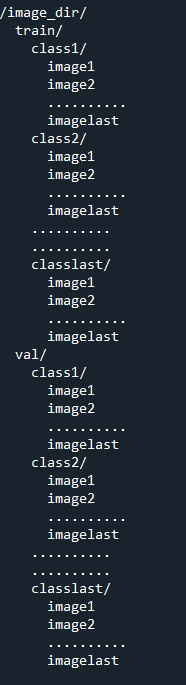

The following code parses the raw Φ-Net Data into this format.

In [4]:
datadir = 'task5/'            # Root directory the Numpy files are stored 
classes = ['GC', 'NC', 'PC']  # Classes corresponding to the labels in the Numpy files
                              # GC: Global collapse, NC: No collapse, PC: Partial collapse

for phase in ['train', 'val']:
    for cl in classes: 
        os.makedirs(datadir + f'data/{phase}/{cl}',exist_ok=True)
        os.makedirs(datadir + f'data/{phase}/{cl}',exist_ok=True)
    if phase=='val':
        phasew = 'test'
    else:
        phasew = 'train'
    ims = np.load(datadir + f'task5_X_{phasew}.npy')
    maxpix = np.amax(ims)
    minpix = np.amin(ims)
    labels = np.load(datadir + f'task5_y_{phasew}.npy')
    labels[:,1]*=2
    labels[:,2]*=3
    labels = (labels[np.where(labels!=0)] - 1).astype(int)
    for im in range(0,len(ims)):
            img = ((ims[im,:,:,:]) - minpix)*255/(maxpix - minpix)
            cl = classes[labels[im]]
            cv2.imwrite(datadir + f'data/{phase}/{cl}/{im}.jpg', img)

## Call BRAILS ImageClassifier to train a classifier model:

**ImageClassifier(modelArch="efficientnetv2s")** initiates the classifier model class object with a classifer architecture. Available architectures are ResNet18, EfficientNet_v2 (small, medium, large), ConvNext (small, base, large), RegNet (16, 32), and Vision Transformer (ViT14, ViT16)

**ImageClassifier.train(trainDataDir='tmp/hymenoptera_data', batchSize=8, nepochs=100)** trains a classifier model for a defined trainDataDir, training batch size and number of epochs.

**ImageClassifier.retrain(modelPath=tmp/models/trained_model.pth,trainDataDir='tmp/hymenoptera_data', batchSize=8, nepochs=100)** further finetunes a classifier model for a defined trainDataDir, training batch size and number of epochs. The defined model in modelPath and the training data in trainDataDir must be compatible to use this method.

In [5]:
from brails.modules import ImageClassifier
imClassifier = ImageClassifier()
imClassifier.train(trainDataDir='task5/data',nepochs=20)

Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth


  0%|          | 0.00/82.7M [00:00<?, ?B/s]

Epoch 0/9
----------
Train Loss: 0.9223 Acc: 0.5734
Val Loss: 0.7231 Acc: 0.6986

Epoch 1/9
----------
Train Loss: 0.7432 Acc: 0.6688
Val Loss: 0.6878 Acc: 0.6986

Epoch 2/9
----------
Train Loss: 0.7030 Acc: 0.6860
Val Loss: 0.6614 Acc: 0.7260

Epoch 3/9
----------
Train Loss: 0.6857 Acc: 0.6884
Val Loss: 0.6161 Acc: 0.7055

Epoch 4/9
----------
Train Loss: 0.6701 Acc: 0.6974
Val Loss: 0.6229 Acc: 0.7260

Epoch 5/9
----------
Train Loss: 0.6277 Acc: 0.7251
Val Loss: 0.6413 Acc: 0.7123

Epoch 6/9
----------
Train Loss: 0.5945 Acc: 0.7447
Val Loss: 0.6426 Acc: 0.7123

Epoch 7/9
----------
Train Loss: 0.5884 Acc: 0.7431
Val Loss: 0.6127 Acc: 0.7123

Epoch 8/9
----------
Train Loss: 0.5187 Acc: 0.7781
Val Loss: 0.6349 Acc: 0.7397

Epoch 9/9
----------
Train Loss: 0.4787 Acc: 0.7896
Val Loss: 0.6122 Acc: 0.7123

Best val Acc: 0.739726
Elapsed time: 5m 14s
New classifier head trained using transfer learning.

Fine-tuning the model...
Epoch 0/9
----------
Train Loss: 0.4954 Acc: 0.7887
Val L

## Plot the change in validation accuracy over training epochs:
**predict(modelPath='tmp/models/trained_model.pth', 
                testDataDir='tmp/hymenoptera_data/val/ants',
                classes=['Ants','Bees'])** loads the model in modelPath and uses this model to predict the classes for the image data in testDataDir using the labels listed in classes. The folder structure for testDataDir must be the same as the structure for trainDataDir

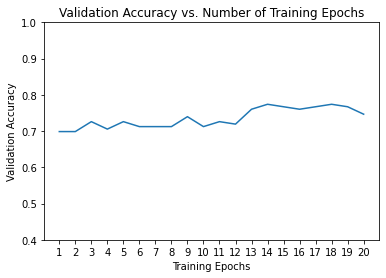

In [10]:
plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,len(imClassifier.lossHistory)+1),imClassifier.lossHistory)
plt.ylim((0.4,1.))
plt.xticks(np.arange(1, len(imClassifier.lossHistory)+1, 1.0))
plt.show()

## Randomly select a number of samples from each class to see how well we predict:

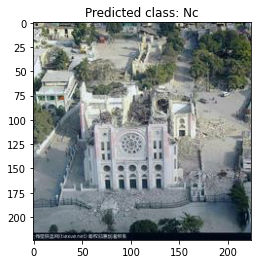

Predicted class: Nc
Actual class: GC


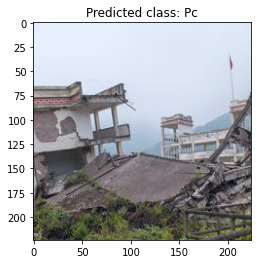

Predicted class: Pc
Actual class: GC


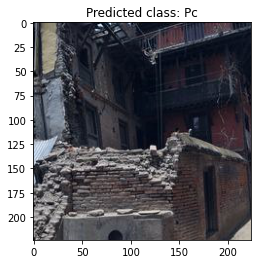

Predicted class: Pc
Actual class: GC


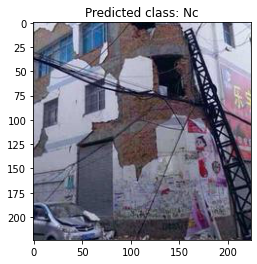

Predicted class: Nc
Actual class: NC


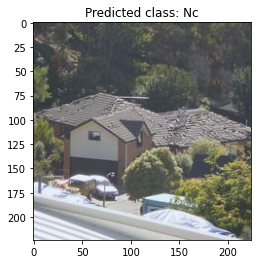

Predicted class: Nc
Actual class: NC


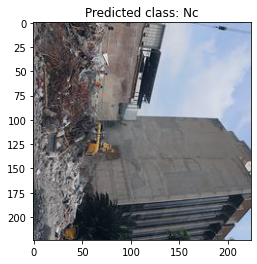

Predicted class: Nc
Actual class: NC


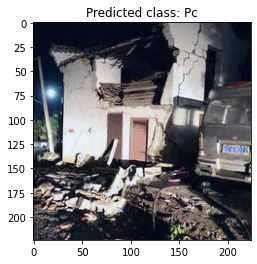

Predicted class: Pc
Actual class: PC


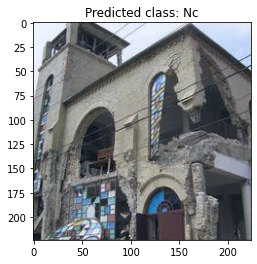

Predicted class: Nc
Actual class: PC


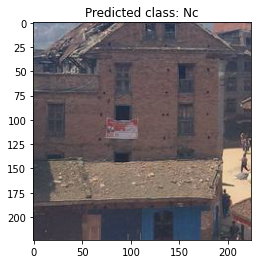

Predicted class: Nc
Actual class: PC


In [11]:
nsamples = 3
for cl in  classes:
    ims = os.listdir(datadir+f'data/val/{cl}')
    samples = random.sample(ims,nsamples)
    for sample in samples:
        imClassifier.predict(testDataDir=datadir+f'data/val/{cl}/{sample}',
                                                  classes = classes)
        print(f'Actual class: {cl}')